In [150]:
import pandas as pd
from pandas.tools.plotting import table
pd.set_option('display.max_colwidth', -1)

import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import spacy
nlp = spacy.load('en')

import tweepy
import os
import six
import subprocess
import csv
import re
import time
import pickle
import preprocessor as p
import itertools
from collections import Counter
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

In [2]:
#add emoji use chart for each artists

# Gathering Tweets with Twitter API (Tweepy)

In [3]:
keys = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/twitterkeys.csv')

In [4]:
ckey = keys.consumer_key[0]
csecret = keys.consumer_secret[0]
atoken = keys.access_token[0]
asecret = keys.access_secret[0]

auth = tweepy.OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)
api = tweepy.API(auth)

In [5]:
def get_tweets(user):    
    tweetlist = []
    tweets = api.user_timeline(screen_name=user, count=200, include_rts=False)
    tweetlist.extend(tweets)
    lastweet = tweetlist[-1].id-1
    
    while len(tweets) > 0:
        tweets = api.user_timeline(screen_name=user, count=200, include_rts=False, max_id=lastweet)
        tweetlist.extend(tweets)
        lastweet = tweetlist[-1].id-1
        print(len(tweetlist), ' downloaded so far')
    
    outtweets = [[tweet.text.encode('utf-8')] for tweet in tweetlist]
    print(outtweets)
    with open (' {}.csv'.format(user), 'w') as f:
        writer = csv.writer(f)
        writer.writerows('t')
        writer.writerows(outtweets)
#Code sourced from https://gist.github.com/yanofsky/5436496

get_tweets('justinbieber')

get_tweets('jtimberlake')
get_tweets('zaynmalik')
get_tweets('chrisbrown')
get_tweets('brunomars')
get_tweets('selenagomez')
get_tweets('ddlovato')
get_tweets('aliciakeys')
get_tweets('ladygaga')
get_tweets('katyperry')


In [6]:
jb = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/justinbieber.csv')
jt = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/jtimberlake.csv')
zm = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/zaynmalik.csv')
cb = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/chrisbrown.csv')
bm = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/brunomars.csv')
sg = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/selenagomez.csv')
dl = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/ddlovato.csv')
ak = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/aliciakeys.csv')
lg = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/ladygaga.csv')
kp = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/katyperry.csv')

In [7]:
jb['artist'] = 'justinbieber'
jt['artist'] = 'justintimberlake'
zm['artist'] = 'zaynmalik'
cb['artist'] = 'chrisbrown'
bm['artist'] = 'brunomars'
sg['artist'] = 'selenagomez'
dl['artist'] = 'demilovato'
ak['artist'] = 'aliciakeys'
lg['artist'] = 'ladygaga'
kp['artist'] = 'katyperry'

In [8]:
artistlist = ['justinbieber', 'justintimberlake', 'zaynmalik', 'chrisbrown', 'brunomars', 'selenagomez', 'demilovato',
             'aliciakeys', 'ladygaga', 'katyperry']

In [9]:
jb.head()

,t,artist
0,b'All love over here Aaron. You got my support',justinbieber
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber
3,b'3 years ago today released #Purpose. Thank you',justinbieber
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber


In [10]:
print(zm.t[0])

b'Thank you @Spotify \xf0\x9f\x99\x8c\xf0\x9f\x8f\xbd \nhttps://t.co/DUMWKSiGYN https://t.co/RlQhR0gRLR'


In [11]:
b'\xf0\x9f\x99\x8c\xf0\x9f\x8f\xbd'.decode()


'🙌🏽'

In [12]:
#Combine the tweets of all artists into one dataframe
alltweets = pd.concat([jb,jt,zm,cb,bm,sg,dl,ak,lg,kp])

In [13]:
#Preprocessor is a python package that preprocesses tweets by removing abundant useless information such as
#emojis urls and symbols.
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION)
alltweets['cleaned'] = alltweets['t'].apply(lambda x: p.clean(x))
alltweets.cleaned = alltweets.cleaned.str.lower()
alltweets.cleaned = alltweets.cleaned.str.strip()
alltweets.cleaned = alltweets.cleaned.str.replace("b'", '')
alltweets.cleaned = alltweets.cleaned.str.replace('b"', '')

In [14]:
#Preprocessor doesnt seem to remove all emojis, and our data is still rather dirty.
def removeemoji(text):
    clean = re.sub(r'\\', '', text)
    clean = re.sub(r'(x..){3,}','',clean)
    return clean

def GetSpecialChar(x):
    special_characters = []
    for char in x:
        if char.isalpha() == False:
            special_characters.append(char)
    return special_characters

special_characters = alltweets.cleaned.apply(lambda x: GetSpecialChar(x))
special_characters = list(set(itertools.chain.from_iterable(special_characters)))
special_characters.remove(' ')

alltweets.cleaned = alltweets.cleaned.apply(lambda x: removeemoji(x))
alltweets.cleaned = alltweets.cleaned.str.replace('\\n', '')
alltweets.cleaned = alltweets.cleaned.str.replace("can't", '')
alltweets.cleaned = alltweets.cleaned.str.replace("won't", '')
alltweets.cleaned = alltweets.cleaned.str.replace('\\nhttps:', '')
alltweets.cleaned = alltweets.cleaned.str.replace('https:', '')
alltweets.cleaned = alltweets.cleaned.str.replace('https://', '')
alltweets.cleaned = alltweets.cleaned.str.replace('\\n', '')
alltweets.cleaned = alltweets.cleaned.str.replace('https', '')
alltweets.cleaned = alltweets.cleaned.str.replace("n't", '')
alltweets.cleaned = alltweets.cleaned.str.replace("'t", '')
alltweets.cleaned = alltweets.cleaned.str.replace("'s", '')
alltweets.cleaned = alltweets.cleaned.str.replace("'re", '')
alltweets.cleaned = alltweets.cleaned.apply(lambda x: re.sub(r'(.)\1{3,}.*$', '', x)) #Removes words with 3+ repeating letters

for char in (special_characters):
    alltweets.cleaned = alltweets.cleaned.str.replace(char, '')
alltweets.cleaned = alltweets.cleaned.str.strip()

alltweets.head()

,t,artist,cleaned
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire


In [15]:
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()
alltweets['tokenized'] = alltweets.cleaned.apply(lambda x: word_tokenize(x))
def removestop(x):
    newlist = []
    for w in x:
        if w not in stopwords and len(w)>1: # Appends words w/ len >1 that are not stop-words to new tokenized list
            w = lem.lemmatize(w)
            newlist.append(w)
    return newlist

alltweets['tokenized'] = alltweets.tokenized.apply(lambda x: removestop(x))
alltweets.head()

,t,artist,cleaned,tokenized
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support,"[love, aaron, got, support]"
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you,"[aaron, carter, album, little, bumped, song, aaron, party, like, need, hype, man, got]"
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires,"[xkarla, donate, portion, proceeds, humane, society, help, animal, hurt, displaced, fire]"
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you,"[year, ago, today, released, purpose, thank]"
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire,"[thank, next, bop, favorite, song, least, song, smash, fire]"


In [16]:
alltweets.tokenized = alltweets.tokenized.apply(lambda x: ' '.join(x))
alltweets.head()

,t,artist,cleaned,tokenized
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support,love aaron got support
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you,aaron carter album little bumped song aaron party like need hype man got
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires,xkarla donate portion proceeds humane society help animal hurt displaced fire
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you,year ago today released purpose thank
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire,thank next bop favorite song least song smash fire


In [17]:
#Remove empty tweets
finaltweets = alltweets[(alltweets.tokenized !='')&(alltweets.tokenized!=' ')]
finaltweets.head()

,t,artist,cleaned,tokenized
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support,love aaron got support
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you,aaron carter album little bumped song aaron party like need hype man got
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires,xkarla donate portion proceeds humane society help animal hurt displaced fire
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you,year ago today released purpose thank
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire,thank next bop favorite song least song smash fire


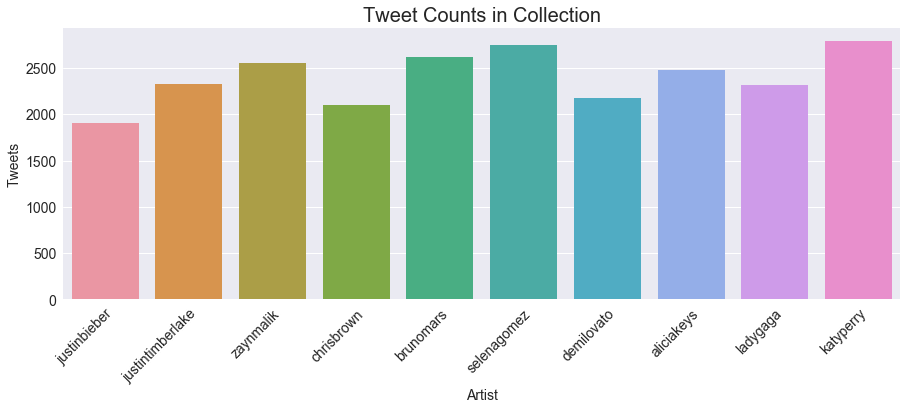

Tweets per Artist 

 katyperry           2797
selenagomez         2753
brunomars           2617
zaynmalik           2555
aliciakeys          2480
justintimberlake    2332
ladygaga            2316
demilovato          2174
chrisbrown          2096
justinbieber        1901
Name: artist, dtype: int64


In [18]:
plt.figure(figsize=(15,5))
sns.countplot(x=finaltweets.artist, data=finaltweets)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('Tweet Counts in Collection', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Artist', fontsize=14)
plt.ylabel('Tweets', fontsize=14)
plt.show()
print('Tweets per Artist','\n\n',finaltweets.artist.value_counts())

In [19]:
finaltweets['numwords'] = finaltweets.cleaned.apply(lambda x: len(x.split()))
finaltweets.head()

C:\Users\JChaotogo\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,t,artist,cleaned,tokenized,numwords
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support,love aaron got support,9
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you,aaron carter album little bumped song aaron party like need hype man got,28
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires,xkarla donate portion proceeds humane society help animal hurt displaced fire,20
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you,year ago today released purpose thank,7
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire,thank next bop favorite song least song smash fire,15


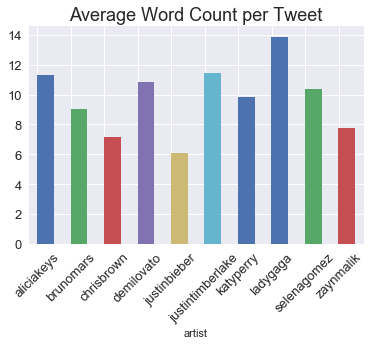

In [98]:
finaltweets.groupby('artist')['numwords'].mean().plot(kind='bar', rot=45, position=.01, grid=True)
plt.title('Average Word Count per Tweet', fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [21]:
#Gets the punctuation count to use as a feature.
def periodcount(x):
    n = 0
    for char in x:
        if char == '.':
            n+=1
    return n

def questioncount(x):
    n = 0
    for char in x:
        if char == '?':
            n+=1
    return n

def exclaimcount(x):
    n = 0
    for char in x:
        if char == '.':
            n+=1
    return n

def hashcount(x):
    n=0
    for char in x:
        if char == '#':
            n+=1
    return n

def mentioncount(x):
    n=0
    for char in x:
        if char == '@':
            n+=1
    return n

In [22]:
finaltweets['hashcount'] = finaltweets.t.apply(lambda x: hashcount(x))
finaltweets['mentioncount'] = finaltweets.t.apply(lambda x: mentioncount(x))

C:\Users\JChaotogo\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\JChaotogo\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
finaltweets.head()

,t,artist,cleaned,tokenized,numwords,hashcount,mentioncount
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support,love aaron got support,9,0,0
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you,aaron carter album little bumped song aaron party like need hype man got,28,0,0
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires,xkarla donate portion proceeds humane society help animal hurt displaced fire,20,0,0
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you,year ago today released purpose thank,7,1,0
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire,thank next bop favorite song least song smash fire,15,0,0


# Bag of Words Model w/ Count Vectorizer

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV


In [119]:
X = finaltweets['tokenized']
Y = finaltweets['artist']

In [120]:
vectorizer = CountVectorizer()
vectorizer.fit(X)
Xdtm = vectorizer.transform(X)
Xdtm

<24021x16387 sparse matrix of type '<class 'numpy.int64'>'
	with 131989 stored elements in Compressed Sparse Row format>

In [121]:
features = pd.DataFrame(Xdtm.toarray(), columns=vectorizer.get_feature_names())
features.shape

(24021, 16387)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(Xdtm, Y, test_size=.3, random_state=0)

In [29]:
lgr = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=3)
lgr.fit(X_train, y_train)
print('Training ACC score:', lgr.score(X_train, y_train))
print(' Testing ACC score:', lgr.score(X_test, y_test))
predy = lgr.predict(X_test)

Training ACC score: 0.8576781253717141
 Testing ACC score: 0.5572360205355904


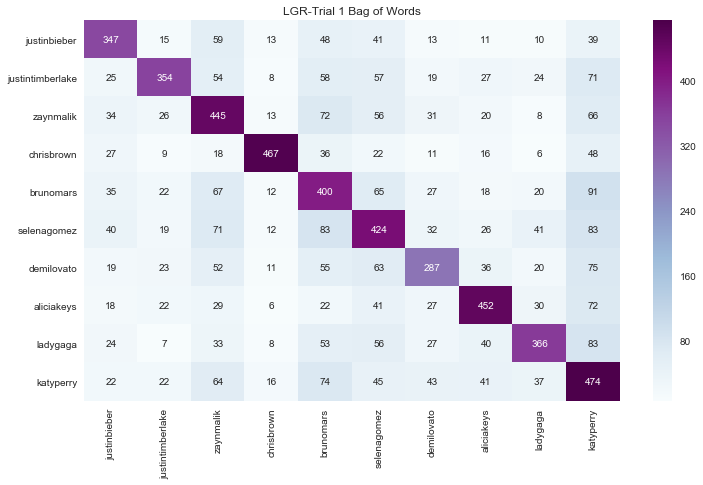

In [30]:
conf1 = confusion_matrix(y_test, predy, labels = artistlist)
df_lgr1 = pd.DataFrame(conf1, index = [i for i in artistlist], columns = [i for i in artistlist])
plt.figure(figsize=(12,7))
sns.heatmap(df_lgr1, annot=True, cmap='BuPu', fmt = 'd')
plt.title('LGR-Trial 1 Bag of Words')
plt.show()

In [112]:
start=time.time()
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
                    max_depth = 5, min_child_weight=1, missing=None, n_estimators=600,
                    n_jobs=3, nthread=None, objective='multi:softmax', num_class=10, random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)
xgb.fit(X_train, y_train)
print(xgb.score(X_train, y_train))
print(xgb.score(X_test, y_test))
predxgb = xgb.predict(X_test)
print('\nClassification Report\n\n', classification_report(y_test, predxgb))
print(time.time()-start)

0.725347924348757
0.5269876508949632

Classification Report

                   precision    recall  f1-score   support

      aliciakeys       0.63      0.62      0.63       719
       brunomars       0.44      0.46      0.45       757
      chrisbrown       0.81      0.67      0.73       660
      demilovato       0.52      0.43      0.47       641
    justinbieber       0.58      0.53      0.55       596
justintimberlake       0.65      0.49      0.56       697
       katyperry       0.34      0.57      0.43       838
        ladygaga       0.63      0.50      0.56       697
     selenagomez       0.48      0.47      0.48       831
       zaynmalik       0.51      0.54      0.53       771

       micro avg       0.53      0.53      0.53      7207
       macro avg       0.56      0.53      0.54      7207
    weighted avg       0.55      0.53      0.53      7207

41.14155411720276


In [123]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [124]:
from lightgbm import LGBMClassifier
start = time.time()
lgb = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
                        learning_rate=0.3, max_depth=4, min_child_samples=20,
                        min_child_weight=.01, min_split_gain=0, n_estimators=700,
                        n_jobs=-1, num_leaves=100, objective='multiclass:softmax', num_class=10, random_state=0,
                        reg_alpha=0, reg_lambda=1, silent=True, subsample=1,
                        subsample_for_bin=200000, subsample_freq=0)
lgb.fit(X_train, y_train)
print(lgb.score(X_train, y_train))
print(lgb.score(X_test, y_test))
predlgb = lgb.predict(X_test)
print('\nClassification Report\n\n', classification_report(y_test, predlgb))
print(time.time()-start)

0.5688117045319376
0.44123768558346055

Classification Report

                   precision    recall  f1-score   support

      aliciakeys       0.57      0.55      0.56       719
       brunomars       0.34      0.37      0.35       757
      chrisbrown       0.78      0.62      0.69       660
      demilovato       0.49      0.32      0.38       641
    justinbieber       0.52      0.42      0.46       596
justintimberlake       0.55      0.41      0.47       697
       katyperry       0.27      0.51      0.35       838
        ladygaga       0.51      0.39      0.44       697
     selenagomez       0.38      0.36      0.37       831
       zaynmalik       0.45      0.47      0.46       771

       micro avg       0.44      0.44      0.44      7207
       macro avg       0.48      0.44      0.45      7207
    weighted avg       0.48      0.44      0.45      7207

14.3606858253479


The first run with logistic regression gave us a decent score of 55.7% accuracy. I can probably improve on this by adding features present in each tweet to the algorithms. Below I'm going to add punctuation counts, word counts, hash counts, and mention counts to the featureset. I included hashs and @ symbols because they are commonly used in twitter to signify trending topics or mention other users.

# Bag of Words with new Features

In [31]:
#Create some new features to try to improve predictions
#Punctuation count
#Length of tweet
finaltweets2 = pd.DataFrame() #make copy of tweets for testing
finaltweets2['p_1'] = finaltweets.t.apply(lambda x: periodcount(x))
finaltweets2['q_1'] = finaltweets.t.apply(lambda x: questioncount(x))
finaltweets2['e_1'] = finaltweets.t.apply(lambda x: exclaimcount(x))
#length of raw tweet
finaltweets2['c_1'] = finaltweets.t.apply(lambda x: len(x))
#Length of tweet w/ stopwords and special characters removed
finaltweets2['c_2'] = finaltweets.tokenized.apply(lambda x: len(x))
finaltweets2['hashcount'] = finaltweets.t.apply(lambda x: hashcount(x))
finaltweets2['mentioncount'] = finaltweets.t.apply(lambda x: mentioncount(x))
finaltweets2['numwords'] = finaltweets['numwords']
finaltweets2.head(20)

,p_1,q_1,e_1,c_1,c_2,hashcount,mentioncount,numwords
0,1,0,1,47,22,0,0,9
1,4,0,4,146,72,0,0,28
2,1,0,1,149,77,0,0,20
3,1,0,1,49,37,1,0,7
4,3,0,3,76,50,0,0,15
5,0,0,0,44,17,0,1,5
7,1,0,1,73,34,0,1,11
8,0,0,0,25,18,0,0,3
9,0,0,0,34,28,0,0,5
10,2,0,2,46,15,0,0,3


In [32]:
finaltweets2.shape

(24021, 8)

In [33]:
#Concat original X with new features
X2 = pd.DataFrame.merge(features, finaltweets2, how='outer', on=features.index)
X2.drop(columns='key_0', inplace=True)
X2.head()

,aa,aaah,aaaw,aadvantage,aah,aahoogaaa,aampe,aampr,aap,aaron,...,zurich,zuzu,p_1,q_1,e_1,c_1,c_2,hashcount,mentioncount,numwords
0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,1,47,22,0,0,9
1,0,0,0,0,0,0,0,0,0,2,...,0,0,4,0,4,146,72,0,0,28
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,149,77,0,0,20
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,49,37,1,0,7
4,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,3,76,50,0,0,15


In [34]:
X2 = scipy.sparse.csc_matrix(X2)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y, test_size=.3, random_state=0)

In [35]:
lgr = LogisticRegression(penalty='l2', solver='lbfgs', multi_class='auto', n_jobs=3)
lgr.fit(X_train2, y_train2)
print('Training ACC score:', lgr.score(X_train2, y_train2))
print(' Testing ACC score:', lgr.score(X_test2, y_test2))
predy2 = lgr.predict(X_test2)
print('\nCross-Tab\n',confusion_matrix(y_test2, predy2))
print('\nClassification Report\n', classification_report(y_test2, predy2))

Training ACC score: 0.30771975734506957
 Testing ACC score: 0.3038712362980436

Cross-Tab
 [[289   4  23   0  16  60 157  93  66  11]
 [ 41  85  17   0  24  90  85  56 169 190]
 [ 77  26 184   0  11 117  46  65  93  41]
 [135  17  12   3  14  67 136  96  78  83]
 [ 22  53  56   0  52 140  25   6 135 107]
 [ 69  26  16   0  50 265  75  77 107  12]
 [101  21  15   0  12  60 307 103  93 126]
 [ 86  19  18   0   4  66 101 242 103  58]
 [ 48  27  10   1  38 113  88 114 307  85]
 [ 24  15   6   0  28  28  80  52  82 456]]

Classification Report
                   precision    recall  f1-score   support

      aliciakeys       0.32      0.40      0.36       719
       brunomars       0.29      0.11      0.16       757
      chrisbrown       0.52      0.28      0.36       660
      demilovato       0.75      0.00      0.01       641
    justinbieber       0.21      0.09      0.12       596
justintimberlake       0.26      0.38      0.31       697
       katyperry       0.28      0.37      0.32

The newly added features seemed to have tanked the accuracy scores. This is probably because the new features are on an entirely different scale from each other. I will use standardscaler to scale all continuous features.

In [36]:
#We now have continuous features that need to be standardized
scaler = StandardScaler()
scaled = scaler.fit_transform(finaltweets2)
scaled = pd.DataFrame(scaled, columns = ['p_1', 'q_1', 'e_1', 'c_1', 'c_2', 'numwords', 'hashcount', 'mentioncount'])
X2 = features.merge(scaled, left_index=True, right_index=True, how='left')
X2.head()

C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,aa,aaah,aaaw,aadvantage,aah,aahoogaaa,aampe,aampr,aap,aaron,...,zurich,zuzu,p_1,q_1,e_1,c_1,c_2,numwords,hashcount,mentioncount
0,0,0,0,0,0,0,0,0,0,1,...,0,0,-0.330187,-0.251006,-0.330187,-0.967206,-0.604652,-0.657743,-0.68864,-0.124450
1,0,0,0,0,0,0,0,0,0,2,...,0,0,1.655318,-0.251006,1.655318,0.951578,1.471080,-0.657743,-0.68864,2.650291
2,0,0,0,0,0,0,0,0,0,0,...,0,0,-0.330187,-0.251006,-0.330187,1.009723,1.678653,-0.657743,-0.68864,1.481979
3,0,0,0,0,0,0,0,0,0,0,...,0,0,-0.330187,-0.251006,-0.330187,-0.928443,0.018067,0.626886,-0.68864,-0.416528
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0.993483,-0.251006,0.993483,-0.405138,0.557758,-0.657743,-0.68864,0.751784


In [37]:
X2 = scipy.sparse.csc_matrix(X2)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y, test_size=.3, random_state=0)

In [38]:
start = time.time()
lgr = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=3)
lgr.fit(X_train2, y_train2)
print('Training ACC score:', lgr.score(X_train2, y_train2))
print(' Testing ACC score:', lgr.score(X_test2, y_test2))
predy2 = lgr.predict(X_test2)
print('\nClassification Report\n', classification_report(y_test2, predy2))
print(time.time()-start)

Training ACC score: 0.8560128464374925
 Testing ACC score: 0.5924795337865963

Classification Report
                   precision    recall  f1-score   support

      aliciakeys       0.70      0.69      0.69       719
       brunomars       0.47      0.53      0.50       757
      chrisbrown       0.85      0.71      0.78       660
      demilovato       0.57      0.44      0.50       641
    justinbieber       0.60      0.65      0.62       596
justintimberlake       0.66      0.61      0.64       697
       katyperry       0.51      0.58      0.54       838
        ladygaga       0.64      0.55      0.59       697
     selenagomez       0.52      0.53      0.52       831
       zaynmalik       0.56      0.65      0.60       771

       micro avg       0.59      0.59      0.59      7207
       macro avg       0.61      0.59      0.60      7207
    weighted avg       0.60      0.59      0.59      7207

4.860799551010132


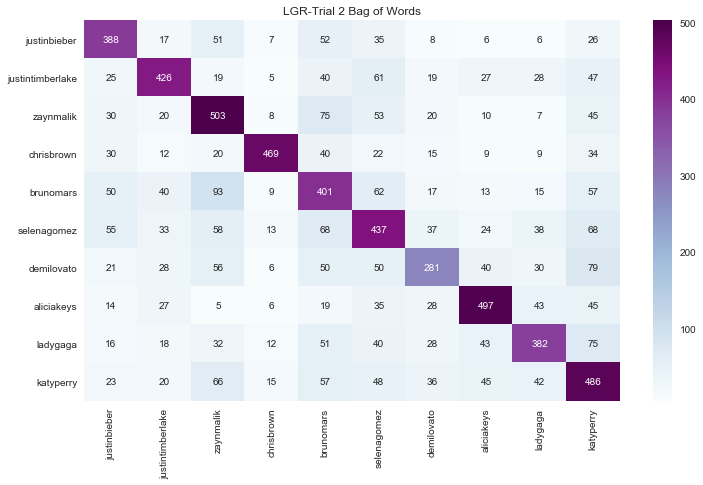

In [39]:
conf2 = confusion_matrix(y_test2, predy2, labels = artistlist)
df_lgr2 = pd.DataFrame(conf2, index = [i for i in artistlist], columns = [i for i in artistlist])
plt.figure(figsize=(12,7))
sns.heatmap(df_lgr2, annot=True, cmap='BuPu', fmt = 'd')
plt.title('LGR-Trial 2 Bag of Words')
plt.show()

In [40]:
start=time.time()
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
                    max_depth = 5, min_child_weight=1, missing=None, n_estimators=600,
                    n_jobs=3, nthread=None, objective='multi:softmax', num_class=10, random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)
xgb.fit(X_train2, y_train2)
print(xgb.score(X_train2, y_train2))
print(xgb.score(X_test2, y_test2))
predxgb2 = xgb.predict(X_test2)
print('\nClassification Report\n\n', classification_report(y_test2, predxgb2))
print(time.time()-start)

0.858689187581777
0.5992784792562786

Classification Report

                   precision    recall  f1-score   support

      aliciakeys       0.67      0.70      0.68       719
       brunomars       0.50      0.51      0.51       757
      chrisbrown       0.83      0.70      0.76       660
      demilovato       0.60      0.44      0.50       641
    justinbieber       0.66      0.65      0.66       596
justintimberlake       0.65      0.65      0.65       697
       katyperry       0.52      0.57      0.54       838
        ladygaga       0.61      0.54      0.57       697
     selenagomez       0.50      0.57      0.53       831
       zaynmalik       0.57      0.68      0.62       771

       micro avg       0.60      0.60      0.60      7207
       macro avg       0.61      0.60      0.60      7207
    weighted avg       0.61      0.60      0.60      7207

73.7650396823883


In [200]:
report = classification_report(y_test2, predxgb2, output_dict=True)
xgbclass = pd.DataFrame(report).transpose()
xgbclass.dtypes

f1-score     float64
precision    float64
recall       float64
support      float64
dtype: object

In [201]:
for column in ['f1-score', 'precision', 'recall']:
    xgbclass[column] = ['{:g}'.format(float('{:.3g}'.format(i))) for i in xgbclass[column]]

In [206]:
xgbclass['artist'] = xgbclass.index
cols = xgbclass.columns.tolist()
cols

['f1-score', 'precision', 'recall', 'support', 'artist']

In [208]:
cols = ['artist', 'precision','recall', 'f1-score', 'support']
xgbclass = xgbclass[cols]

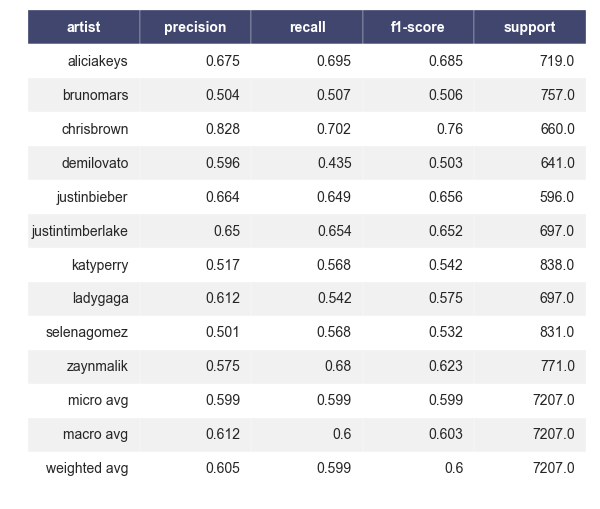

In [209]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(xgbclass, header_columns=0, col_width=2.0)

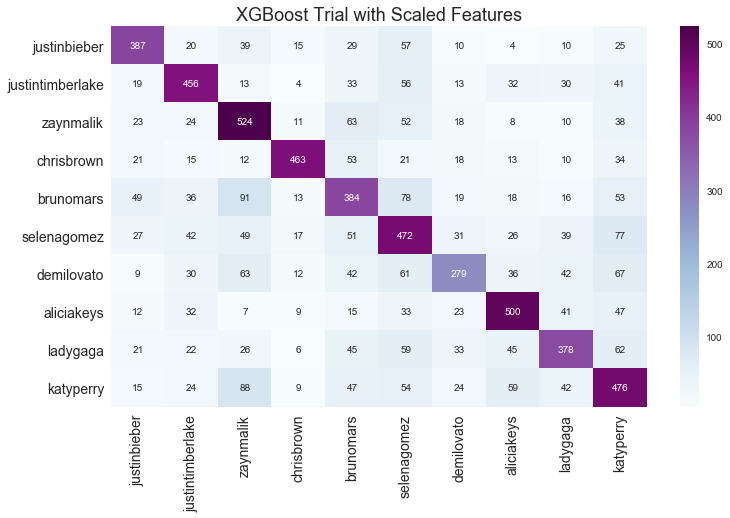

In [146]:
conf3 = confusion_matrix(y_test2, predxgb2, labels = artistlist)
df_lgr3 = pd.DataFrame(conf3, index = [i for i in artistlist], columns = [i for i in artistlist])
plt.figure(figsize=(12,7))
sns.heatmap(df_lgr3, annot=True, cmap='BuPu', fmt = 'd')
plt.title('XGBoost Trial with Scaled Features', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [42]:
from lightgbm import LGBMClassifier
start = time.time()
lgb = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
                        learning_rate=0.3, max_depth=4, min_child_samples=20,
                        min_child_weight=.01, min_split_gain=0, n_estimators=700,
                        n_jobs=-1, num_leaves=100, objective='multiclass:softmax', num_class=10, random_state=0,
                        reg_alpha=0, reg_lambda=1, silent=True, subsample=1,
                        subsample_for_bin=200000, subsample_freq=0)
lgb.fit(X_train2, y_train2)
print(lgb.score(X_train2, y_train2))
print(lgb.score(X_test2, y_test2))
predlgb2 = lgb.predict(X_test2)
print('\nClassification Report\n\n', classification_report(y_test2, predlgb2))
print(time.time()-start)

0.7638277625788034
0.5432218676286943

Classification Report

                   precision    recall  f1-score   support

      aliciakeys       0.62      0.65      0.64       719
       brunomars       0.45      0.44      0.44       757
      chrisbrown       0.78      0.67      0.72       660
      demilovato       0.53      0.36      0.43       641
    justinbieber       0.61      0.63      0.62       596
justintimberlake       0.59      0.58      0.58       697
       katyperry       0.47      0.52      0.49       838
        ladygaga       0.55      0.47      0.51       697
     selenagomez       0.42      0.49      0.46       831
       zaynmalik       0.54      0.63      0.58       771

       micro avg       0.54      0.54      0.54      7207
       macro avg       0.56      0.54      0.55      7207
    weighted avg       0.55      0.54      0.54      7207

23.146331787109375


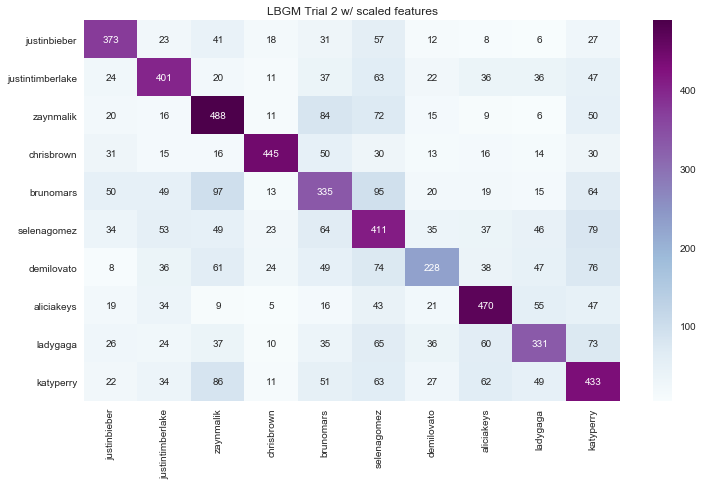

In [43]:
conf4 = confusion_matrix(y_test2, predlgb2, labels = artistlist)
df_lgr4 = pd.DataFrame(conf4, index = [i for i in artistlist], columns = [i for i in artistlist])
plt.figure(figsize=(12,7))
sns.heatmap(df_lgr4, annot=True, cmap='BuPu', fmt = 'd')
plt.title('LBGM Trial 2 w/ scaled features')
plt.show()

# TF-IDF Vectorization of Tweets

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer(max_df=1.0, min_df=1, stop_words='english',
                     lowercase=True, use_idf=True, norm='l2',
                     smooth_idf=True)
tweetstfid = tfid.fit_transform(finaltweets.tokenized)

In [45]:
tfid.get_params

<bound method BaseEstimator.get_params of TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)>

In [46]:
X3 = pd.DataFrame(tweetstfid.toarray())

In [47]:
X3.head()

,0,1,2,3,4,5,6,7,8,9,...,16215,16216,16217,16218,16219,16220,16221,16222,16223,16224
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.755157,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.649226,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, Y, test_size=.3, random_state=0)

In [49]:
start = time.time()
lgr = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=3)
lgr.fit(X_train3, y_train3)
print('Training ACC score:', lgr.score(X_train3, y_train3))
print(' Testing ACC score:', lgr.score(X_test3, y_test3))
predy3 = lgr.predict(X_test3)
print('\nClassification Report\n', classification_report(y_test3, predy3))
print(time.time()-start)

Training ACC score: 0.7867253479243488
 Testing ACC score: 0.5575135285139448

Classification Report
                   precision    recall  f1-score   support

      aliciakeys       0.63      0.64      0.63       719
       brunomars       0.45      0.51      0.48       757
      chrisbrown       0.88      0.68      0.77       660
      demilovato       0.59      0.41      0.49       641
    justinbieber       0.66      0.57      0.61       596
justintimberlake       0.65      0.49      0.56       697
       katyperry       0.40      0.63      0.49       838
        ladygaga       0.62      0.54      0.57       697
     selenagomez       0.46      0.53      0.49       831
       zaynmalik       0.58      0.56      0.57       771

       micro avg       0.56      0.56      0.56      7207
       macro avg       0.59      0.56      0.57      7207
    weighted avg       0.58      0.56      0.56      7207

437.14796233177185


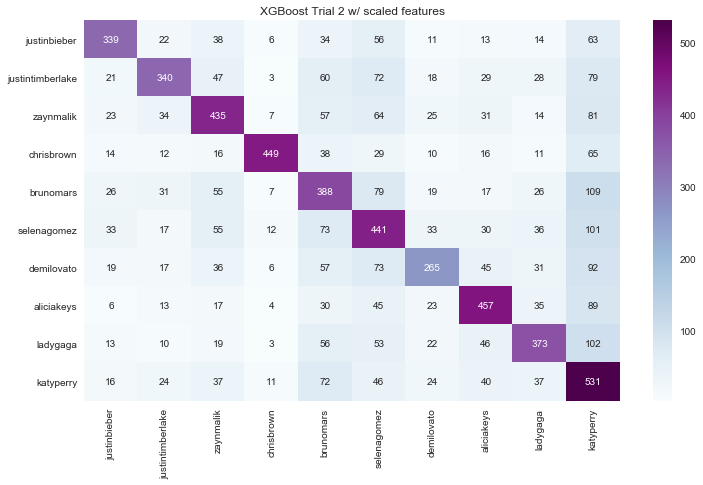

In [50]:
conf5 = confusion_matrix(y_test3, predy3, labels = artistlist)
df_lgr5 = pd.DataFrame(conf5, index = [i for i in artistlist], columns = [i for i in artistlist])
plt.figure(figsize=(12,7))
sns.heatmap(df_lgr5, annot=True, cmap='BuPu', fmt = 'd')
plt.title('XGBoost Trial 2 w/ scaled features')
plt.show()

In [51]:
X3.shape

(24021, 16225)

In [59]:
X4 = pd.DataFrame.merge(X3, scaled, how='outer', on=X3.index)
X4.drop(columns='key_0', inplace=True)
X4.head()

,0,1,2,3,4,5,6,7,8,9,...,16223,16224,p_1,q_1,e_1,c_1,c_2,numwords,hashcount,mentioncount
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.755157,...,0.0,0.0,-0.330187,-0.251006,-0.330187,-0.967206,-0.604652,-0.657743,-0.68864,-0.124450
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.649226,...,0.0,0.0,1.655318,-0.251006,1.655318,0.951578,1.471080,-0.657743,-0.68864,2.650291
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,-0.330187,-0.251006,-0.330187,1.009723,1.678653,-0.657743,-0.68864,1.481979
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,-0.330187,-0.251006,-0.330187,-0.928443,0.018067,0.626886,-0.68864,-0.416528
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.993483,-0.251006,0.993483,-0.405138,0.557758,-0.657743,-0.68864,0.751784


In [60]:
X4.head()

,0,1,2,3,4,5,6,7,8,9,...,16223,16224,p_1,q_1,e_1,c_1,c_2,numwords,hashcount,mentioncount
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.755157,...,0.0,0.0,-0.330187,-0.251006,-0.330187,-0.967206,-0.604652,-0.657743,-0.68864,-0.124450
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.649226,...,0.0,0.0,1.655318,-0.251006,1.655318,0.951578,1.471080,-0.657743,-0.68864,2.650291
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,-0.330187,-0.251006,-0.330187,1.009723,1.678653,-0.657743,-0.68864,1.481979
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,-0.330187,-0.251006,-0.330187,-0.928443,0.018067,0.626886,-0.68864,-0.416528
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.993483,-0.251006,0.993483,-0.405138,0.557758,-0.657743,-0.68864,0.751784


In [61]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, Y, test_size=.3)

In [62]:
start = time.time()
lgr = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=3)
lgr.fit(X_train4, y_train4)
print('Training ACC score:', lgr.score(X_train4, y_train4))
print(' Testing ACC score:', lgr.score(X_test4, y_test4))
predy4 = lgr.predict(X_test4)
print('\nClassification Report\n', classification_report(y_test4, predy4))
print(time.time()-start)

Training ACC score: 0.7531818722493161
 Testing ACC score: 0.5912307478840017

Classification Report
                   precision    recall  f1-score   support

      aliciakeys       0.73      0.66      0.69       796
       brunomars       0.53      0.52      0.52       792
      chrisbrown       0.89      0.66      0.76       611
      demilovato       0.61      0.41      0.49       626
    justinbieber       0.60      0.63      0.61       545
justintimberlake       0.61      0.66      0.63       664
       katyperry       0.52      0.57      0.54       856
        ladygaga       0.58      0.61      0.59       692
     selenagomez       0.51      0.53      0.52       819
       zaynmalik       0.53      0.67      0.59       806

       micro avg       0.59      0.59      0.59      7207
       macro avg       0.61      0.59      0.60      7207
    weighted avg       0.60      0.59      0.59      7207

433.8562159538269


In [63]:
start=time.time()
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
                    max_depth = 5, min_child_weight=1, missing=None, n_estimators=600,
                    n_jobs=3, nthread=None, objective='multi:softmax', num_class=10, random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)
xgb.fit(X_train4, y_train4)
print(xgb.score(X_train4, y_train4))
print(xgb.score(X_test4, y_test4))
predxgb4 = xgb.predict(X_test4)
print('\nClassification Report\n\n', classification_report(y_test4, predxgb4))
print(time.time()-start)

0.878910431783038
0.5898432079922298

Classification Report

                   precision    recall  f1-score   support

      aliciakeys       0.71      0.66      0.69       796
       brunomars       0.50      0.54      0.52       792
      chrisbrown       0.78      0.69      0.73       611
      demilovato       0.56      0.43      0.48       626
    justinbieber       0.62      0.63      0.63       545
justintimberlake       0.61      0.65      0.63       664
       katyperry       0.53      0.55      0.54       856
        ladygaga       0.57      0.58      0.57       692
     selenagomez       0.49      0.53      0.51       819
       zaynmalik       0.61      0.64      0.63       806

       micro avg       0.59      0.59      0.59      7207
       macro avg       0.60      0.59      0.59      7207
    weighted avg       0.59      0.59      0.59      7207

28596.4156665802


In [64]:
start = time.time()
lgb = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                        learning_rate=0.3, max_depth=5, min_child_samples=20,
                        min_child_weight=0.001, min_split_gain=0.0, n_estimators=600,
                        n_jobs=-1, num_leaves=500, objective='multiclass', random_state=None,
                        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                        subsample_for_bin=200000, subsample_freq=0)
lgb.fit(X_train4, y_train4)
print(lgb.score(X_train4, y_train4))
print(lgb.score(X_test4, y_test4))
predlgb4 = lgb.predict(X_test4)
print('Cross-Tab\n\n',confusion_matrix(predlgb4, y_test4))
print('\nClassification Report\n\n', classification_report(y_test4, predlgb4))
print(time.time()-start)

0.820387772094683
0.5335090883862911
Cross-Tab

 [[502  14  13  47   4  40  63  42  33   9]
 [ 12 376  46  34  53  52  69  31  75  90]
 [  6  21 390  16  16  12  16   7  19  16]
 [ 32  26  20 214   9  15  36  34  48  21]
 [ 17  45  25  11 322  33  14  23  49  39]
 [ 35  36  14  41  28 389  30  28  62  20]
 [ 72  70  27  78  24  38 418  72  58  36]
 [ 70  43  20  63  11  30  73 360  54  20]
 [ 44  75  37  67  43  46  56  75 379  60]
 [  6  86  19  55  35   9  81  20  42 495]]

Classification Report

                   precision    recall  f1-score   support

      aliciakeys       0.65      0.63      0.64       796
       brunomars       0.45      0.47      0.46       792
      chrisbrown       0.75      0.64      0.69       611
      demilovato       0.47      0.34      0.40       626
    justinbieber       0.56      0.59      0.57       545
justintimberlake       0.57      0.59      0.58       664
       katyperry       0.47      0.49      0.48       856
        ladygaga       0.48   

# Work in Progress Cosine Similarity

In [65]:
#We can try to compare similarities in the artists' tweets by computing the cosine similarity.
#Here I get the average vector for each artist and compare the similarities between them.
meanvector = []
for artist in artistlist:
    artisttweets = []
    for tweet, art in zip(tweetstfid.toarray(), Y):
        if art == artist:
            artisttweets.append(tweet)
    #Now take the average of the tf-idf rows for this author
    meanvector.append([np.mean(artisttweets, axis = 0), artist])

In [66]:
artistlist

['justinbieber',
 'justintimberlake',
 'zaynmalik',
 'chrisbrown',
 'brunomars',
 'selenagomez',
 'demilovato',
 'aliciakeys',
 'ladygaga',
 'katyperry']

In [67]:
meanvector[1][0]

array([0.        , 0.00054049, 0.00051099, ..., 0.        , 0.00019294,
       0.        ])

In [68]:
m = meanvector[0][0].reshape(-1,1)
n = meanvector[1][0].reshape(-1,1)


In [69]:
from sklearn.metrics.pairwise import cosine_similarity

print(cosine_similarity(m, n, dense_output=False))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Reducing Features with SVD

In [70]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import Normalizer

start = time.time()

pipe = Pipeline(steps=[('svd', TruncatedSVD(3000)), 
                       ('norm', Normalizer(copy=False))])
X3pipe = pipe.fit_transform(X3)

print(time.time()-start)

save_classifier = open('svd3000f.pickle','wb')

pickle.dump(X3pipe, save_classifier)
save_classifier.close()

In [71]:
svd3000load = open('svd3000f.pickle', 'rb')
X3pipe = pickle.load(svd3000load)
svd3000load.close()

#5000 features 97% explained variance
#3000 features 89% explained variance

pipe.get_params()['svd'].explained_variance_ratio_.sum()

In [72]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X3pipe, Y, test_size=.3, random_state=0)

In [73]:
start = time.time()
lgr = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=3)
lgr.fit(X_train4, y_train4)
print('Training ACC score:', lgr.score(X_train4, y_train4))
print(' Testing ACC score:', lgr.score(X_test4, y_test4))
predy4 = lgr.predict(X_test4)
print('\nClassification Report\n', classification_report(y_test4, predy4))
print(time.time()-start)

Training ACC score: 0.5766623052218389
 Testing ACC score: 0.5122797280421812

Classification Report
                   precision    recall  f1-score   support

      aliciakeys       0.55      0.60      0.57       719
       brunomars       0.46      0.44      0.45       757
      chrisbrown       0.93      0.63      0.75       660
      demilovato       0.72      0.28      0.40       641
    justinbieber       0.63      0.51      0.56       596
justintimberlake       0.46      0.59      0.52       697
       katyperry       0.47      0.44      0.45       838
        ladygaga       0.48      0.54      0.50       697
     selenagomez       0.45      0.42      0.44       831
       zaynmalik       0.41      0.68      0.51       771

       micro avg       0.51      0.51      0.51      7207
       macro avg       0.56      0.51      0.52      7207
    weighted avg       0.55      0.51      0.51      7207

109.8847713470459


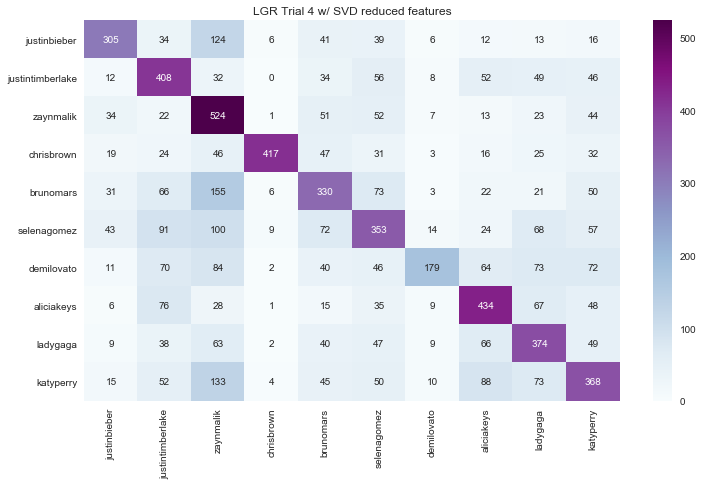

In [74]:
conf6 = confusion_matrix(y_test4, predy4, labels = artistlist)
df_lgr6 = pd.DataFrame(conf6, index = [i for i in artistlist], columns = [i for i in artistlist])
plt.figure(figsize=(12,7))
sns.heatmap(df_lgr6, annot=True, cmap='BuPu', fmt = 'd')
plt.title('LGR Trial 4 w/ SVD reduced features')
plt.show()

X_train3 = scipy.sparse.csc_matrix(X_train3)
X_test3 = scipy.sparse.csc_matrix(X_test3)

start=time.time()
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
                    max_depth = 5, min_child_weight=1, missing=None, n_estimators=600,
                    n_jobs=3, nthread=None, objective='multi:softmax',num_classes=10, random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)
xgb.fit(X_train3, y_train3)
print(xgb.score(X_train3, y_train3))
print(xgb.score(X_test3, y_test3))
predxgb3 = xgb.predict(X_test3)
print('Cross-Tab\n\n',confusion_matrix(predxgb3, y_test3))
print('\nClassification Report\n\n', classification_report(y_test3, predxgb3))
print(time.time()-start)

save_classifier = open('TweetsXGB1.pickle','wb')

pickle.dump(xgb, save_classifier)
save_classifier.close()

In [75]:
start = time.time()
xgbload = open('TweetsXGB1.pickle', 'rb')
xgb = pickle.load(xgbload)
xgbload.close()
print(xgb.score(X_train4, y_train4))
print(xgb.score(X_test4, y_test4))
predxgb4 = xgb.predict(X_test4)
print('\nClassification Report\n\n', classification_report(y_test4, predxgb4))
print(time.time()-start)

0.9930415130248602
0.5443318995421118

Classification Report

                   precision    recall  f1-score   support

      aliciakeys       0.59      0.64      0.61       719
       brunomars       0.45      0.48      0.46       757
      chrisbrown       0.79      0.67      0.72       660
      demilovato       0.50      0.37      0.42       641
    justinbieber       0.68      0.56      0.61       596
justintimberlake       0.57      0.55      0.56       697
       katyperry       0.47      0.51      0.49       838
        ladygaga       0.52      0.54      0.53       697
     selenagomez       0.46      0.52      0.49       831
       zaynmalik       0.53      0.61      0.57       771

       micro avg       0.54      0.54      0.54      7207
       macro avg       0.56      0.54      0.55      7207
    weighted avg       0.55      0.54      0.55      7207

20.69410753250122


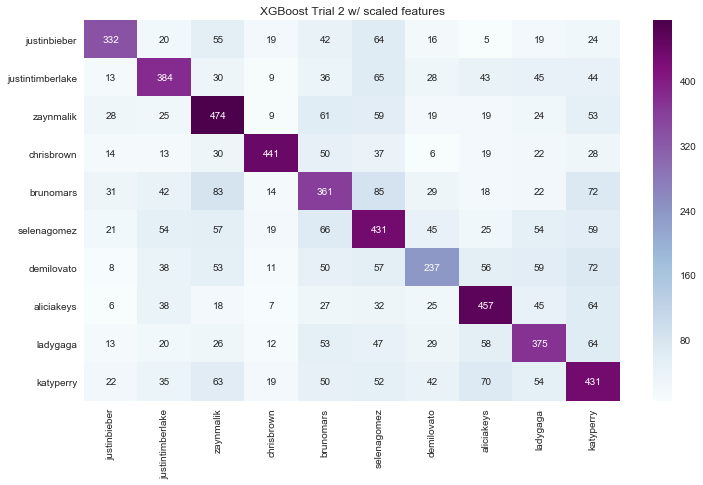

In [76]:
conf7 = confusion_matrix(y_test4, predxgb4, labels = artistlist)
df_lgr7 = pd.DataFrame(conf7, index = [i for i in artistlist], columns = [i for i in artistlist])
plt.figure(figsize=(12,7))
sns.heatmap(df_lgr7, annot=True, cmap='BuPu', fmt = 'd')
plt.title('XGBoost Trial 2 w/ scaled features')
plt.show()

In [77]:
#Add ratio of punctuation/characters

from lightgbm import LGBMClassifier

start = time.time()
lgb = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                        learning_rate=0.3, max_depth=5, min_child_samples=20,
                        min_child_weight=0.001, min_split_gain=0.0, n_estimators=600,
                        n_jobs=-1, num_leaves=500, objective='multiclass', random_state=None,
                        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                        subsample_for_bin=200000, subsample_freq=0)
lgb.fit(X_train3, y_train3)
print(lgb.score(X_train3, y_train3))
print(lgb.score(X_test3, y_test3))
predlgb3 = lgb.predict(X_test3)
print('Cross-Tab\n\n',confusion_matrix(predlgb3, y_test3))
print('\nClassification Report\n\n', classification_report(y_test3, predlgb3))
print(time.time()-start)

save_classifier = open('TweetsLGB1.pickle','wb')

pickle.dump(lgb, save_classifier)
save_classifier.close()

In [78]:
start=time.time()
lgbload = open('TweetsLGB1.pickle', 'rb')
lgb = pickle.load(lgbload)
lgbload.close()
print(lgb.score(X_train4, y_train4))
print(lgb.score(X_test4, y_test4))
predlgb4 = lgb.predict(X_test4)
print('\nClassification Report\n\n', classification_report(y_test4, predlgb4))
print(time.time()-start)

0.7521113357916023
0.5043707506590814

Classification Report

                   precision    recall  f1-score   support

      aliciakeys       0.53      0.60      0.56       719
       brunomars       0.43      0.43      0.43       757
      chrisbrown       0.77      0.66      0.71       660
      demilovato       0.53      0.29      0.37       641
    justinbieber       0.60      0.55      0.57       596
justintimberlake       0.51      0.54      0.52       697
       katyperry       0.43      0.45      0.44       838
        ladygaga       0.48      0.51      0.49       697
     selenagomez       0.41      0.40      0.41       831
       zaynmalik       0.48      0.65      0.55       771

       micro avg       0.50      0.50      0.50      7207
       macro avg       0.52      0.51      0.51      7207
    weighted avg       0.51      0.50      0.50      7207

2.4462506771087646


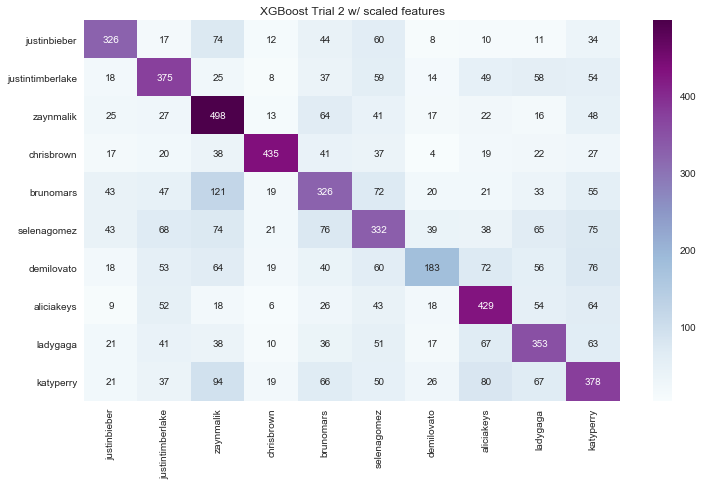

In [79]:
conf8 = confusion_matrix(y_test4, predlgb4, labels = artistlist)
df_lgr8 = pd.DataFrame(conf8, index = [i for i in artistlist], columns = [i for i in artistlist])
plt.figure(figsize=(12,7))
sns.heatmap(df_lgr8, annot=True, cmap='BuPu', fmt = 'd')
plt.title('XGBoost Trial 2 w/ scaled features')
plt.show()

# Word2Vec Implementation

In [80]:
alltweets.head()

,t,artist,cleaned,tokenized
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support,love aaron got support
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you,aaron carter album little bumped song aaron party like need hype man got
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires,xkarla donate portion proceeds humane society help animal hurt displaced fire
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you,year ago today released purpose thank
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire,thank next bop favorite song least song smash fire


In [81]:
tweetlist = ' '.join(alltweets.cleaned[:12000])

In [82]:
tweetlist2 = ' '.join(alltweets.cleaned[12000:])

In [83]:
tweetlist[0:200]

'all love over here aaron you got my support aaron carter i had your album when i was little and bumped the song aarons party i was like  if you need a hype man i got you xkarla will donate a portion o'

In [84]:
len(tweetlist)

499007

In [85]:
tweetlist_doc = nlp(tweetlist)

In [86]:
tweetlist_doc2 = nlp(tweetlist2)

In [87]:
tweets = []
for tweet in tweetlist_doc.sents:
    tweet = [token.lemma_.lower() for token in tweet if not token.is_stop
            and not token.is_punct]
    tweets.append(tweet)
    
for tweet in tweetlist_doc2.sents:
    tweet = [token.lemma_.lower() for token in tweet if not token.is_stop
            and not token.is_punct]
    tweets.append(tweet)
print (tweets[20])
print('We have {} sentences and {} tokens.'.format(len(tweets), len(tweetlist_doc)
                                                   +len(tweetlist_doc2)))

['lyric', 'video', 'friend', 'friend', ' ', 'new', 'song', 'friend', 'hour', 'friend', 'new', 'music', 'thursday', 'noon']
We have 14336 sentences and 248719 tokens.


In [88]:
import gensim
from gensim.models import word2vec

start = time.time()
model = word2vec.Word2Vec(tweets, workers=4, min_count=10, window=6, sg=0, 
                         sample=.001, size=300, hs=1)
print(time.time()-start)

C:\Users\JChaotogo\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


2.755990743637085


In [211]:
vocab = model.wv.vocab.keys()
print(model.wv.most_similar(positive=['teamjt']))

[('theexperience', 0.8859345316886902), ('jttour', 0.8438752889633179), ('pm', 0.8246660232543945), ('iheartradio', 0.8101329803466797), ('pt', 0.7862127423286438), ('perform', 0.7862002849578857), ('jt', 0.7843164205551147), ('finale', 0.7816487550735474), ('kpwww', 0.7796887159347534), ('katy', 0.7792980670928955)]


In [213]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

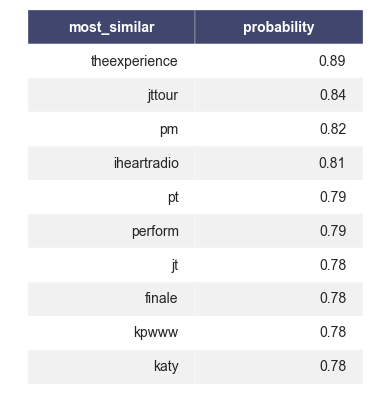

In [219]:
jtex = pd.DataFrame(model.wv.most_similar(positive=['teamjt']), columns = ['most_similar', 'probability'])
jtex.probability = ['{:g}'.format(float('{:.2g}'.format(i))) for i in jtex.probability]
render_mpl_table(jtex)

In [157]:
wvsong = pd.DataFrame(model.wv.most_similar(positive=['song']), columns = ['most_similar', 'probability'])

In [216]:
wvsong.probability = ['{:g}'.format(float('{:.2g}'.format(i))) for i in wvsong.probability]

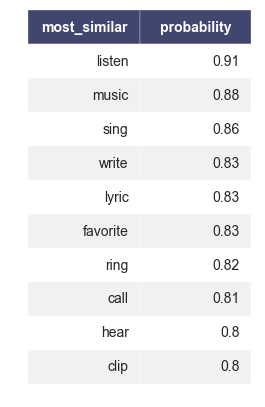

In [217]:
render_mpl_table(wvsong, header_columns=0, col_width=2.0)

The words to vec model doesn't give us accurate similarities most likely because of the small corpus. Some common words aren't represented in the vocabulary. However, this corpus could be helpful when added to a much larger model in order to add information about these artists as well as a slice of the music industry.

In [91]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from os import path
from PIL import Image

In [92]:
jb = ' '.join(finaltweets[finaltweets.artist=='justinbieber']['tokenized'])
jt = ' '.join(finaltweets[finaltweets.artist=='justintimberlake']['tokenized'])
zm = ' '.join(finaltweets[finaltweets.artist=='zaynmalik']['tokenized'])
cb = ' '.join(finaltweets[finaltweets.artist=='chrisbrown']['tokenized'])
bm = ' '.join(finaltweets[finaltweets.artist=='brunomars']['tokenized'])
sg = ' '.join(finaltweets[finaltweets.artist=='selenagomez']['tokenized'])
dl = ' '.join(finaltweets[finaltweets.artist=='demilovato']['tokenized'])
ak = ' '.join(finaltweets[finaltweets.artist=='aliciakeys']['tokenized'])
lg = ' '.join(finaltweets[finaltweets.artist=='ladygaga']['tokenized'])
kp = ' '.join(finaltweets[finaltweets.artist=='katyperry']['tokenized'])

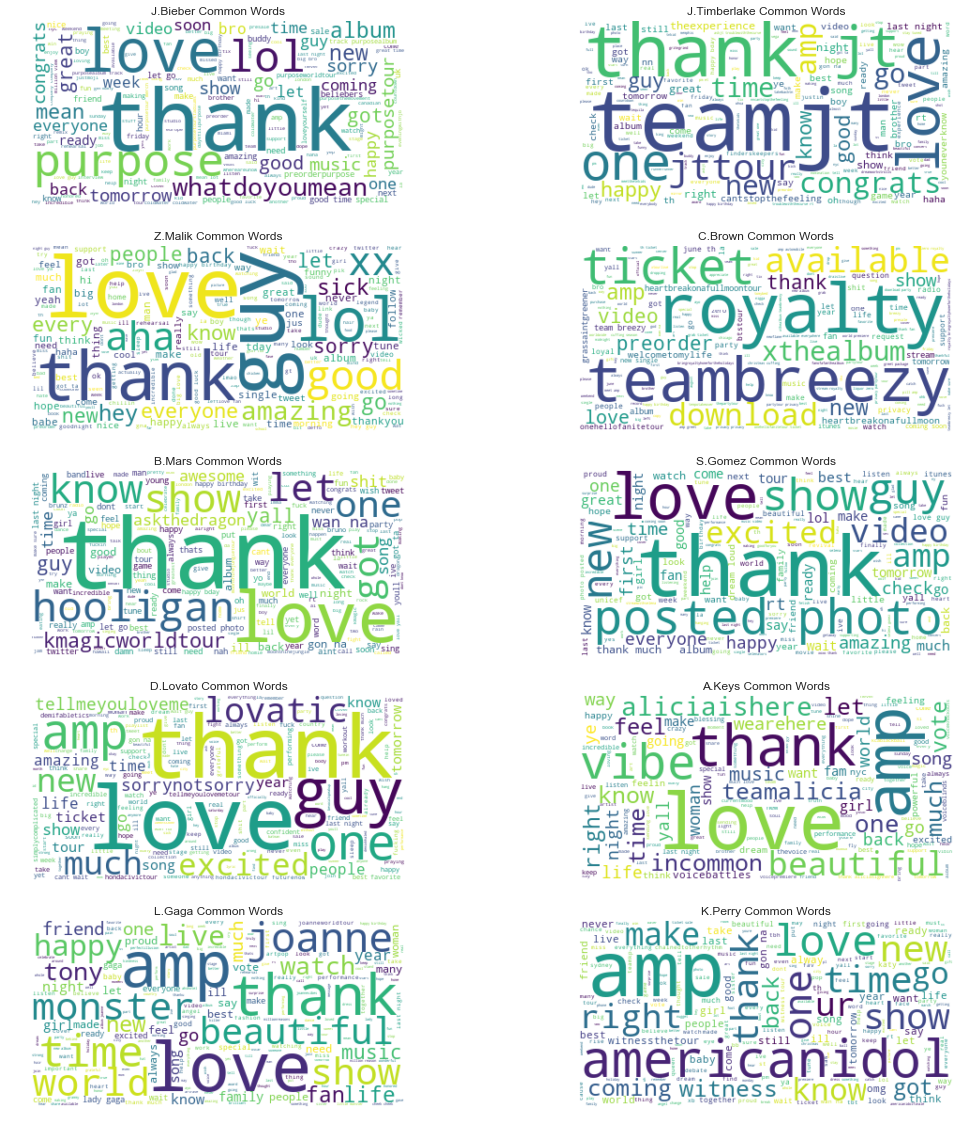

In [93]:
stopwords = set(STOPWORDS)
stopwords.update(['im', 'ha', 'see', 'today', 'tonight', 'day'])
jbw = WordCloud(stopwords=stopwords, background_color='white').generate(jb)
jtw = WordCloud(stopwords=stopwords, background_color='white').generate(jt)
zmw = WordCloud(stopwords=stopwords, background_color='white').generate(zm)
cbw = WordCloud(stopwords=stopwords, background_color='white').generate(cb)
bmw = WordCloud(stopwords=stopwords, background_color='white').generate(bm)
sgw = WordCloud(stopwords=stopwords, background_color='white').generate(sg)
dlw = WordCloud(stopwords=stopwords, background_color='white').generate(dl)
akw = WordCloud(stopwords=stopwords, background_color='white').generate(ak)
lgw = WordCloud(stopwords=stopwords, background_color='white').generate(lg)
kpw = WordCloud(stopwords=stopwords, background_color='white').generate(kp)

plt.figure(figsize=(18,20))
plt.subplot(5,2,1)
plt.imshow(jbw, interpolation='bilinear')
plt.title('J.Bieber Common Words')
plt.axis('off')
plt.subplot(5,2,2)
plt.imshow(jtw, interpolation='bilinear')
plt.title('J.Timberlake Common Words')
plt.axis('off')
plt.subplot(5,2,3)
plt.imshow(zmw, interpolation='bilinear')
plt.title('Z.Malik Common Words')
plt.axis('off')
plt.subplot(5,2,4)
plt.imshow(cbw, interpolation='bilinear')
plt.title('C.Brown Common Words')
plt.axis('off')
plt.subplot(5,2,5)
plt.imshow(bmw, interpolation='bilinear')
plt.title('B.Mars Common Words')
plt.axis('off')
plt.subplot(5,2,6)
plt.imshow(sgw, interpolation='bilinear')
plt.title('S.Gomez Common Words')
plt.axis('off')
plt.subplot(5,2,7)
plt.imshow(dlw, interpolation='bilinear')
plt.title('D.Lovato Common Words')
plt.axis('off')
plt.subplot(5,2,8)
plt.imshow(akw, interpolation='bilinear')
plt.title('A.Keys Common Words')
plt.axis('off')
plt.subplot(5,2,9)
plt.imshow(lgw, interpolation='bilinear')
plt.title('L.Gaga Common Words')
plt.axis('off')
plt.subplot(5,2,10)
plt.imshow(kpw, interpolation='bilinear')
plt.title('K.Perry Common Words')
plt.axis('off')

plt.show()

The most common words for most of the artists seem to be love and thank. This is expected because artist's often use twitter to thank their fans and show love to them. Interestingly, Chris Brown uses love and thank at a much lower frequency than his counterparts. This could have been a factor that the models took into account when classifying each tweet, thus contributing to the high predictibility of Chris Brown's tweets.

Some of the most frequent words in this corpus seem to have no spaces likely because they were used in a hashtag. Hashtags are commonly used when talking about popular topics which explains why these words appear so often.

In [94]:
#>put confusion matrices into heatmap
#>display # of words in a histogram
#>add other visualizations that reflect the features.
#add similarity scores cosine similarility
#>word cloud, plot of all the words in a dataset, words that are more common appear larger in a plot.
#>word cloud can show similarity between artists.
#show what each component is.
#topic modelling, think of additional applications of this project.
#clustering the tweets
#on report mention other things that are happenning with NLP and twitter feeds.

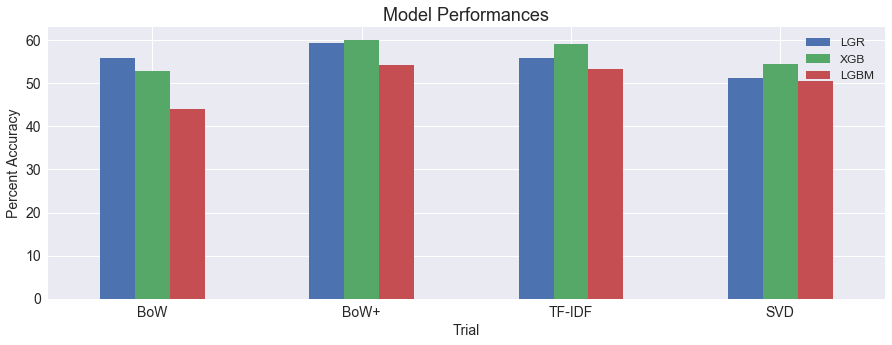

In [210]:
#Graph of model performances for my report

Trial = ['BoW', 'BoW+', 'TF-IDF', 'SVD']
lgr = [55.7, 59.2, 55.8, 51.2]
xgb = [52.7, 60.0, 59.0, 54.4]
lgbm= [44.1, 54.3, 53.3, 50.4]

modelperf = pd.DataFrame(np.c_[lgr, xgb, lgbm], index=Trial)

ax = modelperf.plot.bar(rot=0, figsize=(15,5))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Percent Accuracy', fontsize=14)
plt.xlabel('Trial', fontsize=14)
plt.title('Model Performances', fontsize=18)
ax.legend(['LGR', 'XGB', 'LGBM'], loc='upper right', fontsize=12)

plt.show()